In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import open3d as o3d
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


In [2]:
attr = ['x','y', 'z', 'nx','ny', 'nz', 'diffuse_red', 'diffuse_green', 'diffuse_blue', 'class', 'detection']

In [3]:
path = "./ply/albert.ply"
pd1 = np.loadtxt(path, delimiter=" ", skiprows=15)
df = pd.DataFrame(pd1)
df.columns = attr

## show some points where the y threshold is set to some num

(array([17390.,  2678.,  1203.,   914.,   771.,   389.,   425.,   303.,
          265.,   296.]),
 array([2.9634 , 3.37732, 3.79124, 4.20516, 4.61908, 5.033  , 5.44692,
        5.86084, 6.27476, 6.68868, 7.1026 ]),
 <a list of 10 Patch objects>)

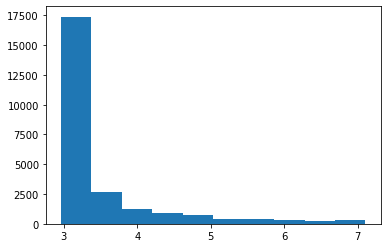

In [4]:
def reject_outliers(data, m=1):
    return abs(data - np.mean(data)) < m * np.std(data)
plt.hist(df['y'][reject_outliers(df['y'], m=.5)])

In [5]:
ythresh = 3
# mask = reject_outliers(df['y'])
mask = reject_outliers(df['x']) & reject_outliers(df['z'])
df1 = df.loc[mask]
# print(f"num pts of just albert {len(df1)}")
df1 = df1.loc[df1['y']<3]
print(f"num pts of just albert {len(df1)}")

num pts of just albert 231000


In [6]:
def write_ply(filename, df):
    header = f'''ply 
    format ascii 1.0
    element vertex {len(df)}
    property float x
    property float y
    property float z
    property float nx
    property float ny
    property float nz
    property uchar diffuse_red
    property uchar diffuse_green
    property uchar diffuse_blue
    property uchar class
    property uchar detection
    end_header
    '''
    with open(filename, "w+") as p:
        p.write(header)
        for i in df1.iterrows():
            p.write(f"{i[1]['x']} {i[1]['y']} {i[1]['z']} {i[1]['nx']} {i[1]['ny']} {i[1]['nz']} {int(i[1]['diffuse_red'])} {int(i[1]['diffuse_green'])} {int(i[1]['diffuse_blue'])} {int(i[1]['class'])} {int(i[1]['detection'])} \n")

In [7]:
#write_ply("./ply/just_albert.ply", df1)

In [8]:
# Load saved point cloud and visualize it
pcd_load = o3d.io.read_point_cloud("./ply/just_albert.ply")
# mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame()
# o3d.visualization.draw_geometries([pcd_load])

# now try to overlay the pts on the image

In [9]:
img = mpimg.imread('./ply/albert.jpg')
w,h = img.shape[1], img.shape[0]
print(f"size {w}, {h} picture")

size 3024, 4032 picture


In [10]:
# so now I scale everything to match the image size

x scale range 0.1311, 4.0943, 3.9631999999999996, to 3024
z scale range -1.803, 2.3351, 4.1381, to 4032


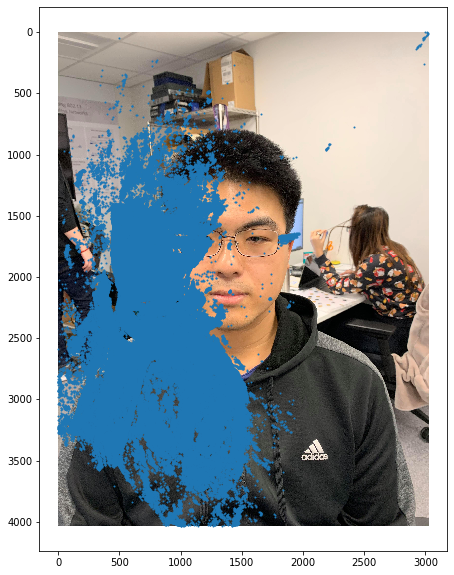

In [11]:
x_min, x_max = min(df1['x']), max(df1['x'])
z_min, z_max = min(df1['z']), max(df1['z'])
print(f"x scale range {x_min}, {x_max}, {x_max-x_min}, to {w}")
print(f"z scale range {z_min}, {z_max}, {z_max-z_min}, to {h}")

x_trans = np.interp(df1['x'], (x_min, x_max), (0, w-1))
y_trans = -1 * np.interp(df1['z'], (z_min, z_max), (0, h-1)) + h


plt.figure(figsize=(10,10))
plt.imshow(img)
plt.scatter( x_trans, y_trans , s=1)

In [12]:
img_mask = np.zeros((h, w, 3))
img_mask[y_trans.astype(int)-1, x_trans.astype(int)-1] = 1
# img_mask[y_trans.astype(int)-1, x_trans.astype(int)-1] = [0,0,0]

In [13]:
img_mask[3189,707]

array([0., 0., 0.])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


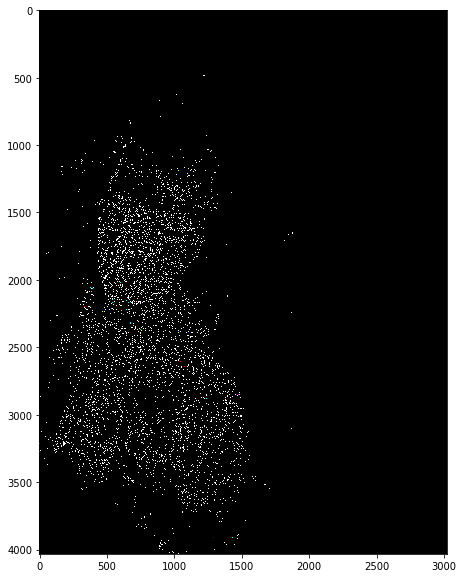

In [14]:
s = img * img_mask
plt.figure(figsize=(10,10))
plt.imshow(s)

# Use grabcut for foreground obj segmentation

In [18]:
import cv2 as cv

In [ ]:
from matplotlib import pyplot as plt

img = cv.imread('./ply/albert.jpg')
mask = np.zeros(img.shape[:2],np.uint8)

# fg_mask = np.zeros((h,w))
# fg_mask[y_trans.astype(int)-1, x_trans.astype(int)-1] = 1
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (1000,100,3024,3024)
# cv.grabCut(img,fg_mask,None,bgdModel,fgdModel,5,cv.GC_INIT_WITH_MASK)
cv.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img1 = img*mask2[:,:,np.newaxis]
plt.imshow(img1),plt.colorbar(),plt.show()

In [83]:
# newmask is the mask image I manually labelled
# newmask = cv.imread('newmask.png',0)

# wherever it is marked white (sure foreground), change mask=1
# wherever it is marked black (sure background), change mask=0
# mask[newmask == 0] = 0
# mask[newmask == 255] = 1
img = cv.imread('./ply/albert.jpg')

fg_mask = np.zeros((h,w))
fg_mask[y_trans.astype(int)-1, x_trans.astype(int)-1] = 1
# bk_mask = np.ones((h, w))
# bk_mask[y_trans.astype(int)-1, x_trans.astype(int)-1] = 0

bgdModel1 = np.zeros((1,65),np.float64)
fgdModel1 = np.zeros((1,65),np.float64)


fg_mask.astype(np.uint8)

mask, bgdModel, fgdModel = cv.grabCut(img,fg_mask,None,bgdModel1,fgdModel1,5,cv.GC_INIT_WITH_MASK)


error: OpenCV(4.1.1) /io/opencv/modules/imgproc/src/grabcut.cpp:334: error: (-5:Bad argument) mask must have CV_8UC1 type in function 'checkMask'


In [ ]:
fg_mask = np.where((fg_mask==2)|(fg_mask==0),0,1).astype('uint8')
img2 = img*fg_mask[:,:,np.newaxis]
plt.imshow(img2),plt.colorbar(),plt.show()